In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Check the root folder
!ls /content/gdrive/

# Path should be visually same as in drive.google.com 
!ls '/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset'

path_to_imgs = '/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskImages'
path_to_labels = '/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskAnnotations'

MyDrive
FaceMaskAnnotations  FaceMaskImages  model.h5  YOLOv3


In [ ]:
# LOAD DATASET
imgs = list(sorted(os.listdir(r'/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskImages')))
labels = list(sorted(os.listdir(r'/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskAnnotations')))

print(len(imgs))

853


In [ ]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 0
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(r'/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskImages')))
        #self.labels = list(sorted(os.listdir(r"C:\Users\adelpc\Documents\Napier\Year 4\Honours Dissertation\Face Mask Dataset\Face Mask Annotations")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(r'/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskImages', file_image)
        label_path = os.path.join(r'/content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskAnnotations', file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([transforms.ToTensor(),])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
#print(f"Device 0: {torch.cuda.get_device_name(0)}")
torch.cuda.is_available()

True

In [ ]:
# MODEL
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(3)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([1, 0, 1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([0, 0, 0, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [ ]:
# TRAIN MODEL
num_epochs = 30 # was 25 
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)
print(len_dataloader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)


214
tensor(54.7936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.9917, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.3856, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.3754, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.3004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.7513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(15.9211, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.9881, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.9328, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.5204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12.7424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.4178, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.8378, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.3545, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.7603, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.6722, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.0930, device='cuda:0',

In [ ]:
!ls /content/gdrive/MyDrive/ColabNotebooks/AutoLabellingHons/FaceMaskDataset/FaceMaskImages/ | grep 8.png

maksssksksss108.png
maksssksksss118.png
maksssksksss128.png
maksssksksss138.png
maksssksksss148.png
maksssksksss158.png
maksssksksss168.png
maksssksksss178.png
maksssksksss188.png
maksssksksss18.png
maksssksksss198.png
maksssksksss208.png
maksssksksss218.png
maksssksksss228.png
maksssksksss238.png
maksssksksss248.png
maksssksksss258.png
maksssksksss268.png
maksssksksss278.png
maksssksksss288.png
maksssksksss28.png
maksssksksss298.png
maksssksksss308.png
maksssksksss318.png
maksssksksss328.png
maksssksksss338.png
maksssksksss348.png
maksssksksss358.png
maksssksksss368.png
maksssksksss378.png
maksssksksss388.png
maksssksksss38.png
maksssksksss398.png
maksssksksss408.png
maksssksksss418.png
maksssksksss428.png
maksssksksss438.png
maksssksksss448.png
maksssksksss458.png
maksssksksss468.png
maksssksksss478.png
maksssksksss488.png
maksssksksss48.png
maksssksksss498.png
maksssksksss508.png
maksssksksss518.png
maksssksksss528.png
maksssksksss538.png
maksssksksss548.png
maksssksksss558.png
maks

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[324.9462,  86.8305, 359.9037, 141.2730],
          [ 79.8975, 103.9413, 109.7515, 141.7127]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9929, 0.9870], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 80.4561,  55.3187, 111.3464,  88.0727],
          [369.1441,  68.7483, 394.6109,  90.1666],
          [318.3830,  32.7240, 350.8177,  70.9675]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 2, 2], device='cuda:0'),
  'scores': tensor([0.9869, 0.3069, 0.0524], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[332.4634,  29.1830, 365.9534,  65.6141],
          [331.0872,  31.3760, 366.8776,  59.5074]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([2, 1], device='cuda:0'),
  'scores': tensor([0.9862, 0.1336], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[354.4256,  34.8660, 376.3661,  56.4

In [ ]:
# PLOTTING
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.detach().cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box, label in zip(annotation["boxes"], annotation["labels"]):
        xmin, ymin, xmax, ymax = box.detach().cpu()
        print(label)
        # 0 has mask 
        if label == 0:
            # Create a Rectangle patch
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add label to the box
            label_name = "with mask"
            ax.text(xmin, ymin, label_name, color='white', fontsize=8, bbox=dict(facecolor='green', alpha=0.5))
        # 2 is mask worn incorrectly
        if label == 2:
            # Create a Rectangle patch
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add label to the box
            label_name = "mask worn incorrectly"
            ax.text(xmin, ymin, label_name, color='white', fontsize=8, bbox=dict(facecolor='orange', alpha=0.5))
        if label == 1: # no mask
             # Create a Rectangle patch
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add label to the box
            label_name = "without mask"
            ax.text(xmin, ymin, label_name, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))


    plt.show()

4
Prediction
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')


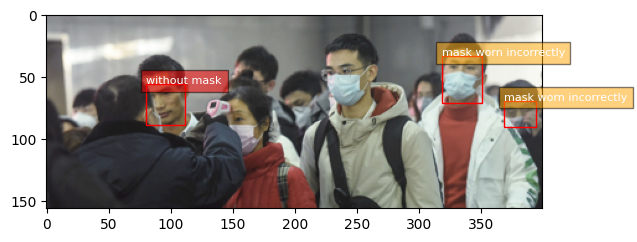

Target
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)


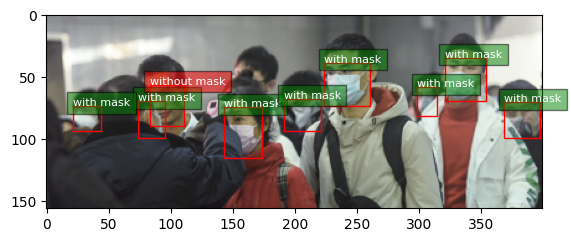

In [ ]:
print(len(imgs))
ImageID = 1
# Move the tensors to the CPU before plotting
img_to_plot = imgs[ImageID].cpu()
annotation_to_plot = {k: v.cpu() for k, v in annotations[ImageID].items()}

# Call the plot_image function with tensors on the CPU
print("Prediction")
plot_image(img_to_plot, preds[ImageID])
print("Target")
plot_image(img_to_plot, annotation_to_plot)

In [ ]:
torch.save(model.state_dict(),'model25.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

In [ ]:
# SAVE MODEL
model2.load_state_dict(torch.load('model25.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Predict with loaded model
tensor(1, device='cuda:0')


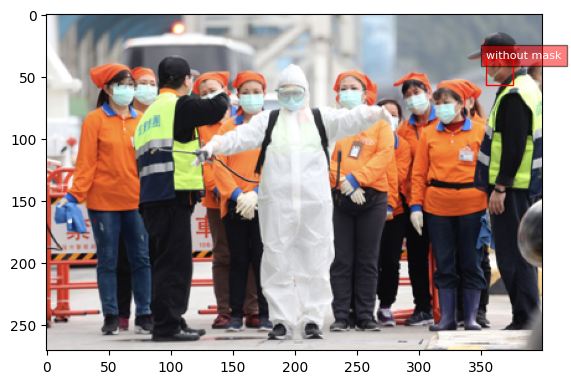

In [ ]:
# LOAD MODEL
pred2 = model2(imgs)
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])

In [ ]:
import numpy as np

def calculate_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area
    iou = inter_area / union_area
    return iou

def calculate_mAP(predictions, ground_truth, iou_threshold=0.5):
    num_classes = max([p['class_id'] for p in predictions] + [g['class_id'] for g in ground_truth]) + 1
    all_aps = []
    for class_id in range(num_classes):
        class_preds = [p for p in predictions if p['class_id'] == class_id]
        class_gt = [g for g in ground_truth if g['class_id'] == class_id]
        class_preds.sort(key=lambda x: x['confidence'], reverse=True)
        tp = np.zeros(len(class_preds))
        fp = np.zeros(len(class_preds))
        gt_count = len(class_gt)
        gt_used = np.zeros(gt_count)

        for i, pred in enumerate(class_preds):
            max_iou = -1
            max_gt_idx = -1
            for j, gt in enumerate(class_gt):
                if gt['image_id'] != pred['image_id']:
                    continue
                iou = calculate_iou(pred['bbox'], gt['bbox'])
                if iou > max_iou:
                    max_iou = iou
                    max_gt_idx = j
            if max_iou >= iou_threshold and gt_used[max_gt_idx] == 0:
                tp[i] = 1
                gt_used[max_gt_idx] = 1
            else:
                fp[i] = 1

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        precision = tp_cumsum / (tp_cumsum + fp_cumsum)
        recall = tp_cumsum / gt_count
        precision = np.concatenate(([0.0], precision, [1.0]))
        recall = np.concatenate(([0.0], recall, [1.0]))
        for i in range(precision.size - 1, 0, -1):
            precision[i - 1] = max(precision[i - 1], precision[i])

       
        ap = np.sum(precision[1:] - precision[:-1]) * recall[1:]
        all_aps.append(ap)
        # Compute mAP as the mean of APs across all classes
    mAP = np.mean(all_aps)
    return mAP


In [ ]:
# Replace `predictions` and `ground_truth` with your actual data
# `predictions` and `ground_truth` should be lists of dictionaries containing
# information about the predicted and true bounding boxes, classes, confidence
# scores (for predictions), and image IDs.

# Calculate mAP
#mAP = calculate_mAP(predictions, ground_truth)

# Display the mAP value
#print("Mean Average Precision (mAP):", mAP)
